In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from dynamoUtil import price_bar_query

In [66]:
# print(plt.style.available)
def plot_chains(data_dict, metric, mode='combined', selected_chain=None):
    """
    plot data for different chains.(combnied or single)

    Parameters:
    data_dict (dict): dict of dataframes, key is chain name, value is dataframe.
    metric (str): metric type（'fee'、'tvl'、'volume'）.
    mode (str): 'combined' means plot data for same metric，'single' means plot data for different chains, different metric.
    selected_chain (str): used under only 'single' mode, specify the chain name.
    """
    if mode == 'combined':
        plt.figure(figsize=(14, 7))
        
        for chain_name, df in data_dict.items():
            plt.plot(df['date'], df['value'], label=chain_name)

        plt.xlabel('Date')
        plt.ylabel(f'{metric.capitalize()} Value')
        plt.title(f'{metric.capitalize()} Over Time for Different Chains')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend(loc='best')
        plt.tight_layout()
        
        output_folder = './results/combined_charts'
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        # save the plot
        
        plt.savefig(os.path.join(output_folder,f'combined_{metric}_chart.png'))
        print(f"combined {metric} has been saved as combined_{metric}_chart.png")
        plt.show()
        plt.close()
        
    elif mode == 'single':
        if selected_chain is None:
            raise ValueError("In 'single' mode, you must specify 'selected_chain'.")
        
        if selected_chain not in data_dict:
            raise ValueError(f"Chain '{selected_chain}' not found in data.")

        df = data_dict[selected_chain]

        plt.style.use('seaborn-v0_8')

        plt.figure(figsize=(14, 7))

        plt.plot(df['date'], df['value'], color='royalblue', linewidth=2.5, label=f'{selected_chain} {metric}')
    
        plt.xlabel('Date', fontsize=14, fontweight='bold')
        plt.ylabel(f'{metric.capitalize()} Value', fontsize=14, fontweight='bold')
        plt.title(f'{selected_chain} {metric.capitalize()} Over Time', fontsize=16, fontweight='bold')
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(visible=True, linestyle='--', linewidth=0.5)
        plt.legend(loc='best', fontsize=12)
        plt.tight_layout()

        output_folder = './results/output_single_charts'
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        plt.savefig(os.path.join(output_folder, f'{selected_chain}_{metric}_single_chart.png'))
        print(f"{selected_chain} {metric} has been saved as {selected_chain}_{metric}_single_chart.png")
        plt.show()
        plt.close()


In [67]:
def plot_chain_zscore(data_dict_all, chain_name, metric, window_size=30, threshold=2):
    """
    compute Z score for a single metric of a single chain and plot the anomaly detection chart.

    Parameters:
    - data_dict_all (dict): all data of 150 days.
    - chain_name (str): name of the chain
    - metric (str): metric type（'fee'、'tvl'、'volume'）.
    - window_size (int): size of the rolling window, default 30.
    - threshold (int): z score threshold, default 2.
    """
    df = data_dict_all[metric][chain_name].copy()

    df['rolling_mean'] = df['value'].rolling(window=window_size).mean()
    df['rolling_std'] = df['value'].rolling(window=window_size).std()

    df['z_score'] = (df['value'] - df['rolling_mean']) / df['rolling_std']

    df['is_anomaly'] = df['z_score'].abs() > threshold

    df_plot = df.tail(120)

    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(14, 7))

    plt.plot(df_plot['date'], df_plot['value'], color='royalblue', linewidth=2.5, label='Value')

    plt.plot(df_plot['date'], df_plot['rolling_mean'], color='orange', linestyle='--', linewidth=2, label=f'{window_size}-day Rolling Mean')

    anomalies = df_plot[df_plot['is_anomaly']]
    plt.scatter(anomalies['date'], anomalies['value'], color='red', s=60, edgecolor='black', label='Anomalies', zorder=5)

    plt.xlabel('Date', fontsize=14, fontweight='bold')
    plt.ylabel(f'{metric.capitalize()} Value', fontsize=14, fontweight='bold')
    plt.title(f'{chain_name} {metric.capitalize()} Over Time with Z-Score Anomalies (Last 120 Days)', fontsize=18, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(visible=True, linestyle='--', linewidth=0.5)
    plt.legend(loc='best', fontsize=12)
    plt.tight_layout()
    
    output_folder = './results/z_score_charts'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    plt.savefig(os.path.join(output_folder, f'{selected_chain}_{metric}_Z.png'))
    print(f"{selected_chain} {metric} has been saved {selected_chain}_{metric}_Z.png")
    plt.show()
    plt.close()

combined tvl has been saved as combined_tvl_chart.png


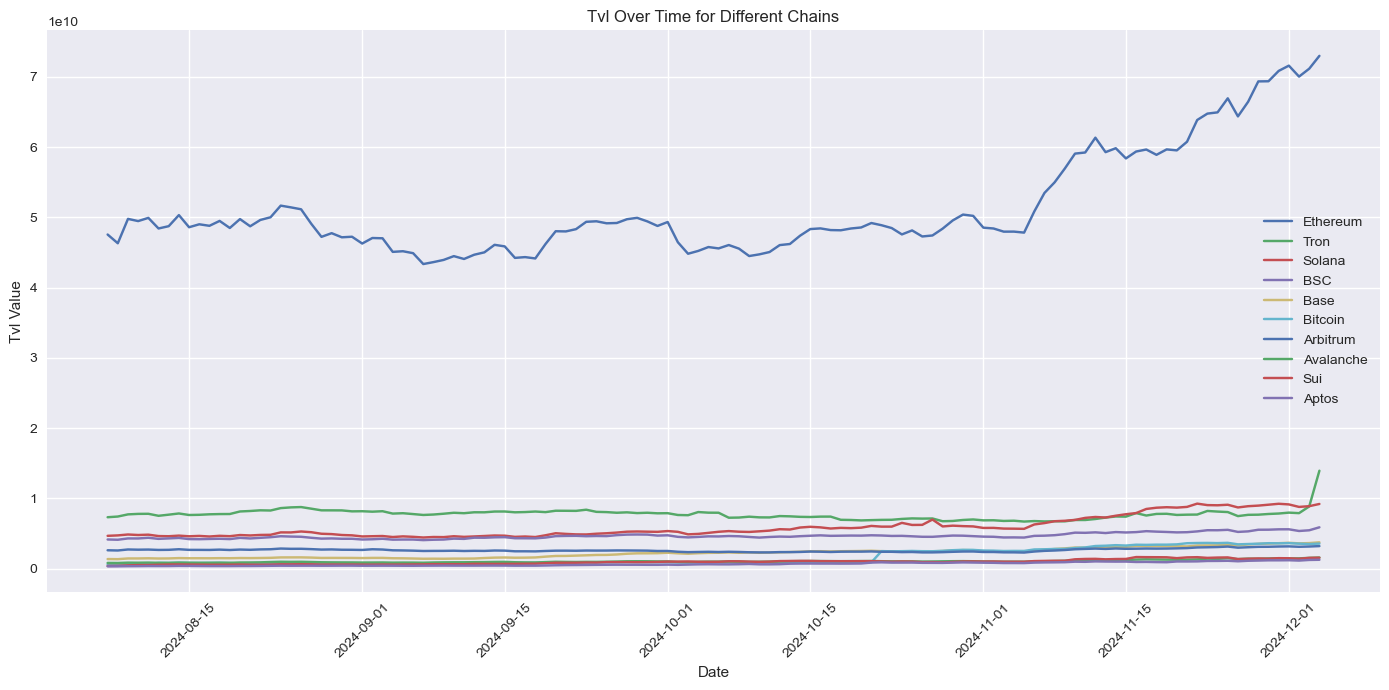

combined fee has been saved as combined_fee_chart.png


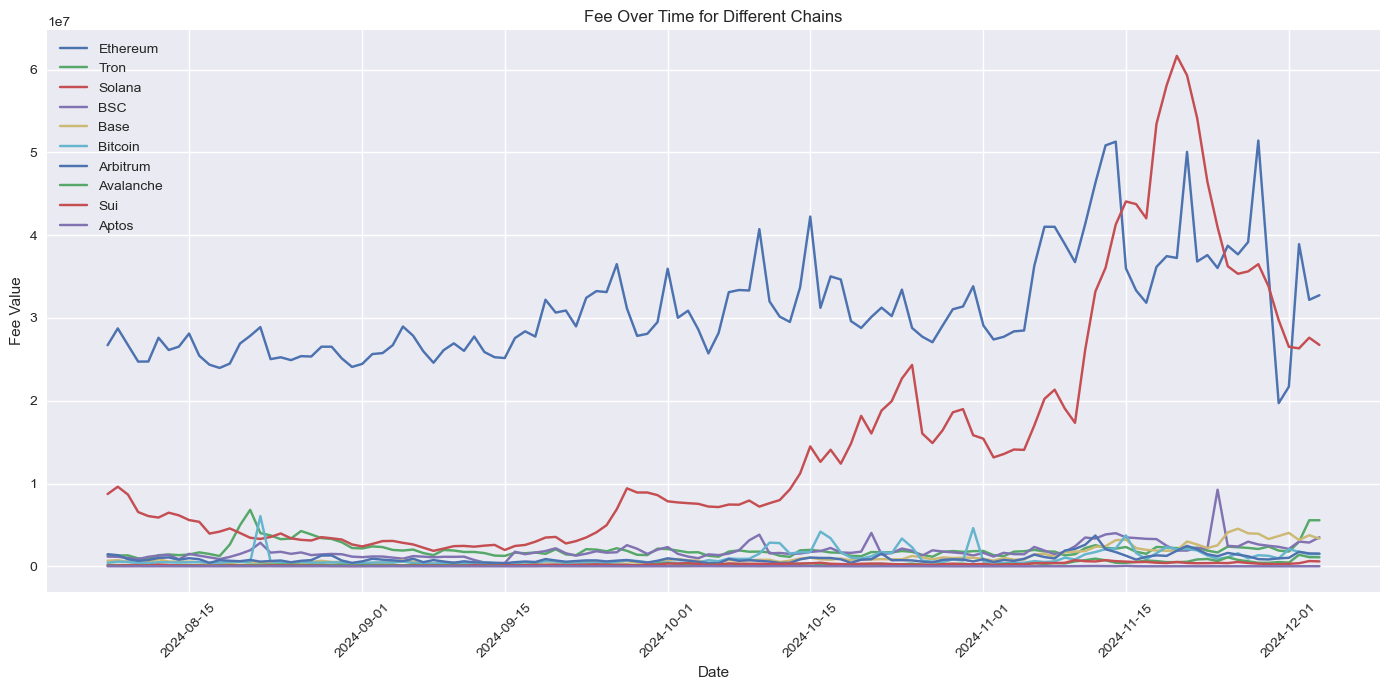

combined volume has been saved as combined_volume_chart.png


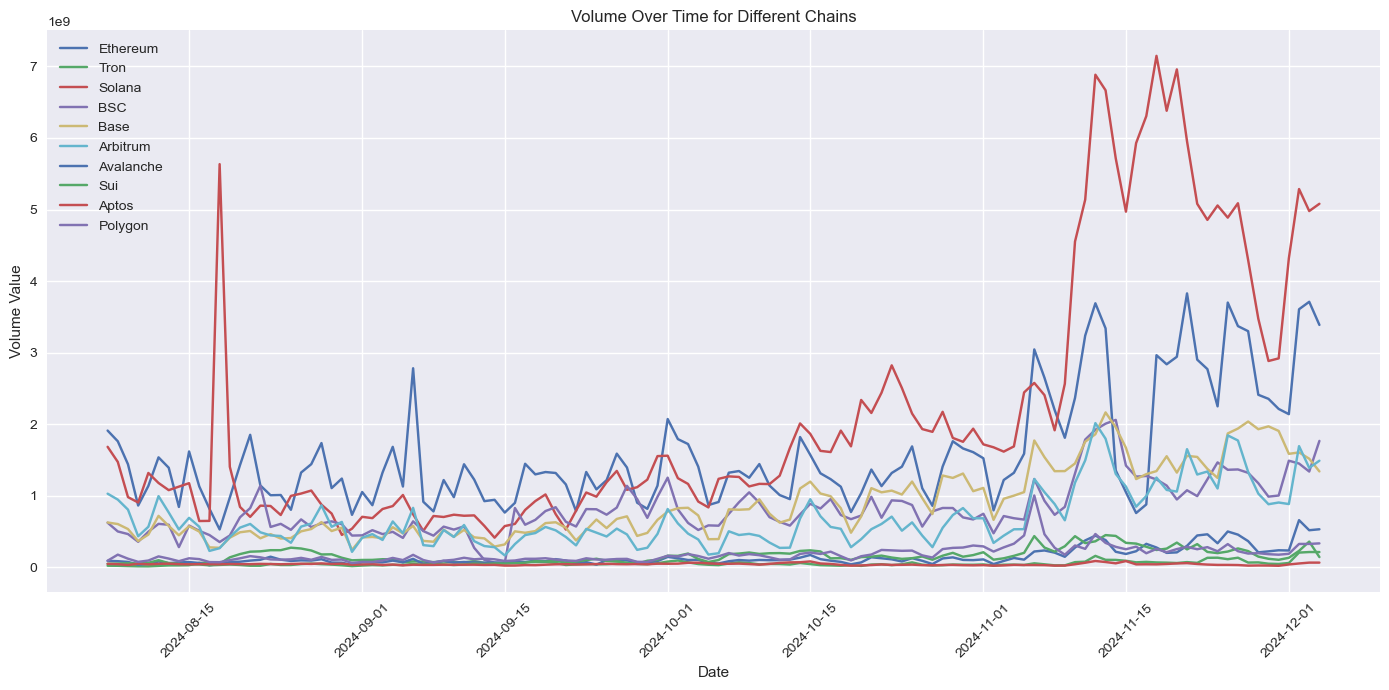

Ethereum fee has been saved as Ethereum_fee_single_chart.png


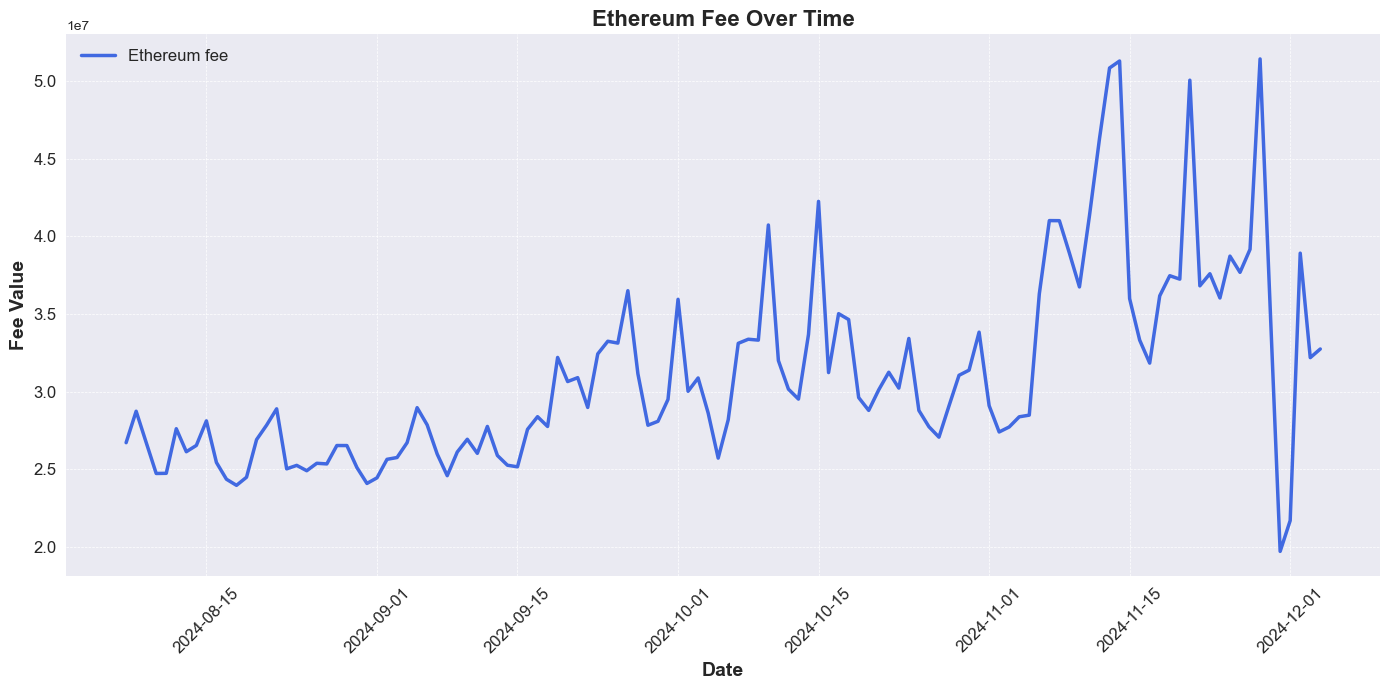

Ethereum fee has been saved Ethereum_fee_Z.png


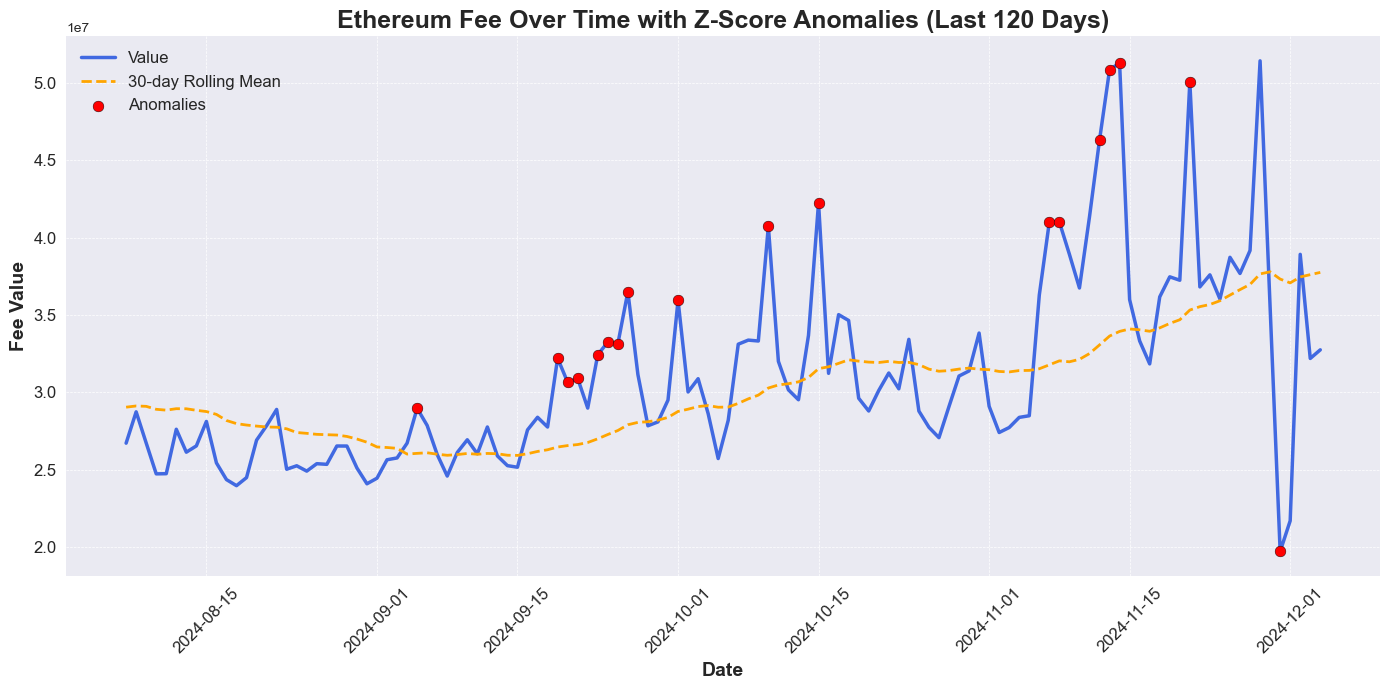

In [ ]:

data_folder = 'data'
subfolders = ['fee', 'tvl', 'volume']

data_dict = {} # this one is for the last 120 days
data_dict_all = {} # this one is for all data, cuz we need to compute z-score

# read data
for subfolder in subfolders:
    folder_path = os.path.join(data_folder, subfolder)
    if os.path.exists(folder_path):
        csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])

        data_dict[subfolder] = {}
        data_dict_all[subfolder] = {}

        for csv_file in csv_files:
            chain_name = csv_file.split('_')[1]

            csv_path = os.path.join(folder_path, csv_file)
            df = pd.read_csv(csv_path)

            df.columns = ['date', 'value'] if subfolder == 'fee' else ['date', subfolder]
            df.rename(columns={subfolder: 'value'}, inplace=True)
            df['date'] = pd.to_datetime(df['date'])

            data_dict[subfolder][chain_name] = df.tail(120)
            data_dict_all[subfolder][chain_name] = df

plot_chains(data_dict['tvl'], 'tvl', mode='combined')
plot_chains(data_dict['fee'], 'fee', mode='combined')
plot_chains(data_dict['volume'], 'volume', mode='combined')

selected_chain = 'Ethereum'
plot_chains(data_dict['fee'], 'fee', mode='single', selected_chain=selected_chain)
plot_chain_zscore(data_dict_all, chain_name='Ethereum', metric='fee')



In [ ]:

price_bar_query(primary_key_value, sorting_key_start_value, sorting_key_end_value='', env='live')